In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow import keras as kr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import matplotlib.pyplot as plt

In [2]:
# upload
print('Uploading...')
exp_matrix = pd.read_csv('/root/work/data/sub/brca_exp_sub', index_col=0)
label = pd.read_csv('/root/work/data/sub/brca_label_sub')
print('Uploading done!')

Uploading...
Uploading done!


In [3]:
# data preprocessing
x = exp_matrix.T

# str -> int
y = np.array(label['BRCA_Subtype_PAM50'].map({'LumA':0, 'LumB':1, 'Basal':2, 'Her2':3, 'Normal':4}).astype(int))

train_x, test_x, train_y_t, test_y_t = train_test_split(x, y, test_size=0.3, random_state=np.random.seed())
print(train_x.shape, test_x.shape, train_y_t.shape, test_y_t.shape)

# int -> onthot
train_y = kr.utils.to_categorical(train_y_t)
test_y = kr.utils.to_categorical(test_y_t)

(670, 12411) (288, 12411) (670,) (288,)


In [5]:
model = Sequential()
model.add(Dense(1024, input_dim=train_x.shape[1], kernel_initializer='uniform', activation='LeakyReLU'))
model.add(Dropout(0.1))
model.add(Dense(128,kernel_initializer='uniform',activation='relu'))
model.add(Dense(128,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5,kernel_initializer='uniform',activation='softmax'))

model.compile(loss=kr.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
#sgd = kr.optimizers.SGD(learning_rate=0.001)

Epoch 1/50
5/5 [==============================] - 2s 205ms/step - loss: 1.1838 - categorical_accuracy: 0.5406 - val_loss: 0.5183 - val_categorical_accuracy: 0.7313
Epoch 2/50
5/5 [==============================] - 0s 92ms/step - loss: 0.5562 - categorical_accuracy: 0.7678 - val_loss: 0.6875 - val_categorical_accuracy: 0.8060
Epoch 3/50
5/5 [==============================] - 0s 60ms/step - loss: 0.4663 - categorical_accuracy: 0.8209 - val_loss: 0.6014 - val_categorical_accuracy: 0.7910
Epoch 4/50
5/5 [==============================] - 0s 76ms/step - loss: 0.3635 - categorical_accuracy: 0.8557 - val_loss: 0.3044 - val_categorical_accuracy: 0.8657
Epoch 5/50
5/5 [==============================] - 0s 81ms/step - loss: 0.2552 - categorical_accuracy: 0.8872 - val_loss: 0.2915 - val_categorical_accuracy: 0.8806
Epoch 6/50
5/5 [==============================] - 0s 90ms/step - loss: 0.1851 - categorical_accuracy: 0.9386 - val_loss: 0.3579 - val_categorical_accuracy: 0.8806
Epoch 7/50
5/5 [=====

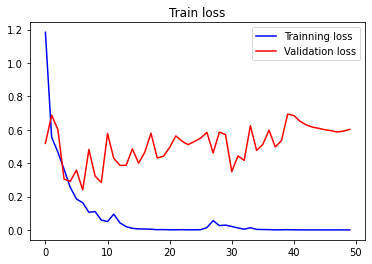

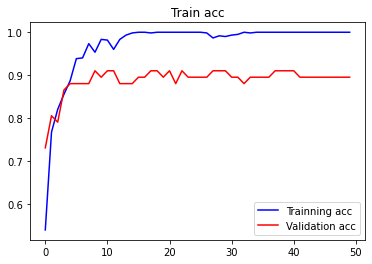

In [6]:
b = 128
train_history=model.fit(train_x,
                        train_y,
                        epochs=50,
                        validation_split=0.1,
                        batch_size=b)

loss=train_history.history['loss']
acc=train_history.history['categorical_accuracy']
epochs=range(0,len(loss))
plt.title("Train loss")
plt.plot(epochs,loss,'b',label='Trainning loss')
val_loss=train_history.history['val_loss']
val_acc=train_history.history['val_categorical_accuracy']
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.legend(loc='best')
plt.figure()
plt.title("Train acc")
plt.plot(epochs,acc,'b',label='Trainning acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.legend(loc='best')
plt.show()

In [4]:
from keras.models import load_model

# # 保存训练好的model为hdf5文件
# model.save('/root/work/model/brca_subtype_model.h5')  
# 重新加载模型
model = load_model('/root/work/model/brca_subtype_model.h5')

In [5]:
loss, accuracy = model.evaluate(test_x, test_y)
print('test loss: ', loss)
print('test accuracy: ', accuracy)

9/9 [==============================] - 0s 5ms/step - loss: 0.0879 - categorical_accuracy: 0.9722
test loss:  0.08793947100639343
test accuracy:  0.9722222089767456


In [6]:
from scipy import interp
from sklearn.metrics import roc_curve, auc

n_classes = train_y.shape[1]
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = model.predict(test_x)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


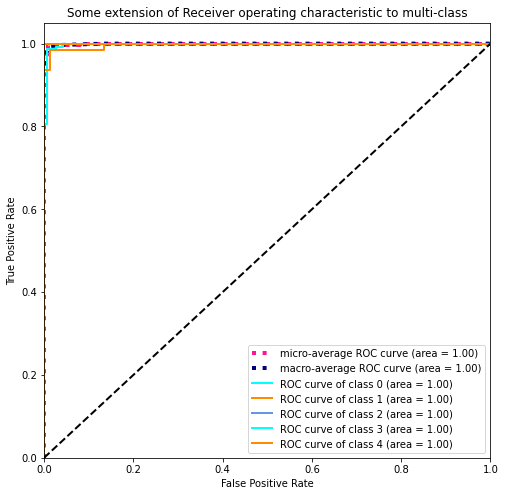

In [9]:
from itertools import cycle
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = np.argmax(test_y, axis=-1).reshape(test_y.shape[0],1)
y_pred = np.argmax(model.predict(test_x).astype(np.int64), axis=-1).reshape(test_y.shape[0],1)
cm = confusion_matrix(y_true,y_pred)
cm = pd.DataFrame(cm, columns=['LumA', 'LumB', 'Basal', 'Her2', 'Normal'], index=['LumA', 'LumB', 'Basal', 'Her2', 'Normal'])
cm

,LumA,LumB,Basal,Her2,Normal
LumA,143,0,0,0,0
LumB,55,6,0,0,0
Basal,14,0,43,0,0
Her2,19,0,0,2,0
Normal,6,0,0,0,0


In [15]:
cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(formatter={"float": "{: 0.3f}".format})
cm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


,LumA,LumB,Basal,Her2,Normal
LumA,1.000000,0.000000,0.000000,0.000000,0.0
LumB,0.901639,0.098361,0.000000,0.000000,0.0
Basal,0.245614,0.000000,0.754386,0.000000,0.0
Her2,0.904762,0.000000,0.000000,0.095238,0.0
Normal,1.000000,0.000000,0.000000,0.000000,0.0


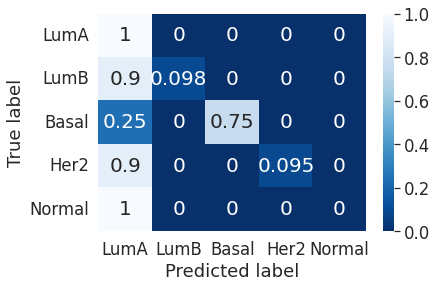

In [16]:
sns.set(font_scale=1.5)
plt.rc('font',size=20)
sns.heatmap(cm,cmap="Blues_r",annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

my = []
rf = []
dt = []
svm = []
lr = []
knn = []
nb = []

for i in range(10):
    # my

    train_x, test_x, train_y_t, test_y_t = train_test_split(x, y, test_size=0.3, random_state=np.random.seed())
    print(train_x.shape, test_x.shape, train_y_t.shape, test_y_t.shape)
    # int -> onthot
    train_y = kr.utils.to_categorical(train_y_t)
    test_y = kr.utils.to_categorical(test_y_t)
    loss, accuracy = model.evaluate(test_x, test_y)
    my.append(accuracy)

    clf=RandomForestClassifier()  
    clf = clf.fit(train_x,train_y_t)
    score1 = clf.score(test_x,test_y_t)
    rf.append(score1)

    clf2 = tree.DecisionTreeClassifier()
    clf2 = clf2.fit(train_x, train_y_t)
    score2 = clf2.score(test_x,test_y_t)
    dt.append(score2)

    clf3 = SVC(kernel='linear')
    clf3.fit(train_x,train_y_t)
    y_pred = clf3.predict(test_x)
    score3 = metrics.accuracy_score(test_y_t, y_pred)
    svm.append(score3)

    clf4 = linear_model.LogisticRegression(C=1e5)
    clf4.fit(train_x,train_y_t)
    score4 = clf4.score(test_x,test_y_t)
    lr.append(score4)

    clf5 = KNeighborsClassifier()
    clf5.fit(train_x,train_y_t)
    y_pred = clf5.predict(test_x)
    score5 = metrics.accuracy_score(test_y_t, y_pred)
    knn.append(score5)

    clf6 = GaussianNB()
    clf6 = clf6.fit(train_x,train_y_t)
    y_pred = clf6.predict(test_x)
    score6 = metrics.accuracy_score(test_y_t, y_pred)
    nb.append(score6)

evaluate_result = pd.DataFrame([my,rf,dt,svm,lr,knn,nb], index=['my','rf','dt','svm','lr','knn','nb'])
evaluate_result

(670, 12411) (288, 12411) (670,) (288,)
9/9 [==============================] - 0s 5ms/step - loss: 0.0206 - categorical_accuracy: 0.9931
(670, 12411) (288, 12411) (670,) (288,)
9/9 [==============================] - 0s 5ms/step - loss: 0.0432 - categorical_accuracy: 0.9931
(670, 12411) (288, 12411) (670,) (288,)
9/9 [==============================] - 0s 5ms/step - loss: 0.0677 - categorical_accuracy: 0.9861
(670, 12411) (288, 12411) (670,) (288,)
9/9 [==============================] - 0s 5ms/step - loss: 0.0465 - categorical_accuracy: 0.9826
(670, 12411) (288, 12411) (670,) (288,)
9/9 [==============================] - 0s 5ms/step - loss: 0.0488 - categorical_accuracy: 0.9965
(670, 12411) (288, 12411) (670,) (288,)
9/9 [==============================] - 0s 5ms/step - loss: 0.1065 - categorical_accuracy: 0.9826
(670, 12411) (288, 12411) (670,) (288,)
9/9 [==============================] - 0s 5ms/step - loss: 0.0510 - categorical_accuracy: 0.9931
(670, 12411) (288, 12411) (670,) (288,)
9

In [20]:
# preprocess for the other ML methods
x = exp_matrix.T
y = np.array(label['BRCA_Subtype_PAM50'])

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=np.random.seed())
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(472, 9742) (203, 9742) (472,) (203,)


In [21]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=1)  #n_estimators表示弱学习器的最大迭代次数，或者说最大的弱学习器的个数。如果设置值太小，模型容易欠拟合；如果太大，计算量会较大，并且超过一定的数量后，模型提升很小
clf = clf.fit(train_x,train_y_t)
score1 = clf.score(test_x,test_y_t)
print('Random Forest Classifier result:', score1)

Random Forest Classifier result: 0.7326388888888888


In [22]:
# Desicion Tree
from sklearn import tree

clf2 = tree.DecisionTreeClassifier()
clf2 = clf2.fit(train_x, train_y_t)
score2 = clf2.score(test_x,test_y_t)
print('Decision Tree Classifier result:', score2)

Decision Tree Classifier result: 0.7465277777777778


In [23]:
# SVM
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics

clf3 = SVC(kernel='rbf')
clf3.fit(train_x,train_y)
y_pred = clf3.predict(test_x)
print(metrics.classification_report(test_y, y_pred))

              precision    recall  f1-score   support

       Basal       1.00      0.95      0.97        37
        Her2       0.82      0.60      0.69        15
        LumA       0.85      0.90      0.88       103
        LumB       0.66      0.72      0.69        40
      Normal       1.00      0.50      0.67         8

    accuracy                           0.84       203
   macro avg       0.87      0.73      0.78       203
weighted avg       0.84      0.84      0.84       203



In [24]:
# Logistic Regression
from sklearn import linear_model

clf4 = linear_model.LogisticRegression()
clf4.fit(train_x,train_y)
score4 = clf4.score(test_x,test_y)
print('Logistic Regression result:', score4)

Logistic Regression result: 0.8177339901477833


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [25]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

clf5 = KNeighborsClassifier(n_neighbors=3)
clf5.fit(train_x,train_y)
y_pred = clf5.predict(test_x)
print(metrics.classification_report(test_y, y_pred))

              precision    recall  f1-score   support

       Basal       0.97      0.81      0.88        37
        Her2       0.67      0.27      0.38        15
        LumA       0.69      0.90      0.78       103
        LumB       0.54      0.33      0.41        40
      Normal       0.38      0.38      0.38         8

    accuracy                           0.70       203
   macro avg       0.65      0.54      0.57       203
weighted avg       0.70      0.70      0.68       203



In [26]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

clf6 = GaussianNB()
clf6 = clf6.fit(train_x,train_y)
y_pred = clf6.predict(test_x)
print(metrics.classification_report(test_y, y_pred))

              precision    recall  f1-score   support

       Basal       1.00      0.89      0.94        37
        Her2       0.61      0.73      0.67        15
        LumA       0.91      0.70      0.79       103
        LumB       0.54      0.72      0.62        40
      Normal       0.42      1.00      0.59         8

    accuracy                           0.75       203
   macro avg       0.70      0.81      0.72       203
weighted avg       0.81      0.75      0.77       203



In [15]:
import tensorflow as tf
def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # # 2. Preprocess the interpolated images
    # interpolated_image = xception.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

In [ ]:
x = np.array(test_x.iloc[0])
img_size = x.shape
top_k = int(len(x)/100)

for num in range(len(test_x)):
    print(num)
    s = np.array(test_x.iloc[num]).reshape(1,test_x.shape[1])
    x = np.array(test_x.iloc[num])
    preds = model.predict(s)

    top_pred_idx = tf.argmax(preds[0])
    igrads = random_baseline_integrated_gradients(np.copy(x), top_pred_idx=top_pred_idx, num_steps=50, num_runs=2)
    igrads = np.array(igrads).reshape(1,test_x.shape[1])

    if num == 0:
        igs = igrads
    else:
        igs = np.concatenate((igs, igrads), axis=0)
preds = model.predict(test_x)
preds = np.argmax(preds, axis=1)
preds_y = pd.DataFrame(preds, columns=['class'])

idx_0 = preds_y.index[preds_y['class']==0].to_list()
idx_1 = preds_y.index[preds_y['class']==1].to_list()
idx_2 = preds_y.index[preds_y['class']==2].to_list()
idx_3 = preds_y.index[preds_y['class']==3].to_list()
idx_4 = preds_y.index[preds_y['class']==4].to_list()

igs = pd.DataFrame(igs, columns=test_x.columns)

sub_0 = igs.loc[idx_0]
sub_1 = igs.loc[idx_1]
sub_2 = igs.loc[idx_2]
sub_3 = igs.loc[idx_3]
sub_4 = igs.loc[idx_4]
# LumA
row_mean = pd.DataFrame(sub_0.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/brca_sub0_igs_mean')

# LumB
row_mean = pd.DataFrame(sub_1.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/brca_sub1_igs_mean')

# Basal
row_mean = pd.DataFrame(sub_2.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/brca_sub2_igs_mean')

# Her2
row_mean = pd.DataFrame(sub_3.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/brca_sub3_igs_mean')

# Normal
row_mean = pd.DataFrame(sub_4.mean(axis=0), columns=['mean']).sort_values('mean', inplace=False)
row_mean.to_csv('/root/work/multi/brca_sub4_igs_mean')